In [11]:
#!pip install --upgrade pip setuptools wheel
#!python -m pip install opencv-python
#!pip install matplotlib
#!pip freeze
#!pip install opencv-python-headless
#!pip install scikit-image

In [3]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from os import sep
from os.path import join
from skimage.feature import blob_dog, blob_log, blob_doh

### IMAGE PROCESSING - PREPROCESSING

In [18]:
#https://github.com/MujtabaAhmad0928/SCRS/blob/fe2f6a7ed9fd1897f8c47da509b2c8a399ea4910/preprocessing.py
def hair_removal_BH(matrix, kernel_size = 17):
    # grayscale
    gray = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY )
    # blackhat 
    kernel = cv2.getStructuringElement(1,(kernel_size,kernel_size))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    # threshold
    ret,th = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # impainting
    output = cv2.inpaint(matrix, th, 1, cv2.INPAINT_TELEA)
    return output

In [19]:
# from bansal paper laplacian of gaussian + top hat morphology
def hairRemoval_LoG_THM(matrix, ksize = 3, kernel_size = 17, filterSize = (11, 11)):
    # 1. grayscale
    gray = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY)
    
    # 2. laplacian of gaussian
    # steps are blurring,
    #           laplacian,
    #           zero_crossing,
    #           threshold zero crossing to extract strong edges
    ddepth = cv2.CV_16S
    blur = cv2.GaussianBlur(gray, (ksize, ksize), 0)
    lp = cv2.Laplacian(blur, ddepth, ksize=ksize)
    # converting output back to uint8
    log = cv2.convertScaleAbs(lp)

    # 3. closing and dilation
    kernel = cv2.getStructuringElement(1,(kernel_size,kernel_size))
    close = cv2.morphologyEx(log, cv2.MORPH_CLOSE, kernel)
    dil = cv2.dilate(close, kernel)
    
    # 4. top-hat transformation   
    kernel_th = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                          filterSize)
    
    tophat = cv2.morphologyEx(dil, 
                              cv2.MORPH_TOPHAT,
                              kernel_th)
    # 5. otsu
    #thresh = cv2.threshold(sharp, 0, 255, cv2.THRESH_OTSU )[1]
    # 6. erosion and closing
    # 7. impainting
    
    return log, close, dil, tophat

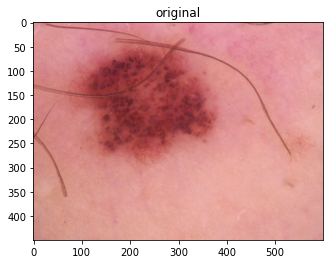

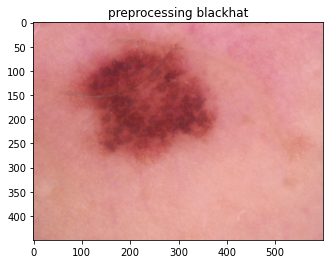

In [22]:
FOLDER_DIR = "/home/emily/Desktop/CAD/train/"

imgnevus = cv2.imread(join(FOLDER_DIR,"nevus", "nev{}.jpg".format("03178")))
# 00656 02056 01831 00547 02237  02462 02655  03178 03284   04438  05209 
# 04762 04176 cute
# 00246 05464 02758 02462 02379 shity
# 03863 finger

img_rgb = cv2.cvtColor(imgnevus, cv2.COLOR_BGR2RGB)

nevus = np.array(img_rgb)
plt.imshow(nevus)
plt.title('original')
plt.show()

output_bh = hair_removal_BH(imgnevus)

plt.imshow(cv2.cvtColor(output_bh, cv2.COLOR_BGR2RGB))
plt.title('preprocessing blackhat')
plt.show()


In [ ]:
# laplacian of gaussian top hat morphological operation
log, close, dil, tophat = hairRemoval_LoG_THM(imgnevus)

plt.imshow(log, cmap='gray')
plt.title('log')
plt.show()

plt.imshow(close, cmap='gray')
plt.title('closing')
plt.show()

plt.imshow(dil, cmap='gray')
plt.title('dilation')
plt.show()

plt.imshow(tophat, cmap='gray')
plt.title('tophat')
plt.show()

## FEATURES EXTRACTION

### ABCD Rule

commonly used feature extraction method from dermoscopic images is based on the ABCD rule of dermatoscopu nachbar et al 1994.  this method consider 4 criteria: 

- asymmetry
- border structure
- color variation
- diameter of skin lesion.